<a href="https://colab.research.google.com/github/taimur1871/Coursera_Capstone/blob/master/Denver_Food_Truck_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Food Truck Location Planner</h1>

<h3>Business Problem</h3>

This project aims to analyze open data for a city to determine the best places to for a food truck business. In this case we are assuming that a friend has a food truck that serves tacos. They want to find out where in city they should plan to spend most of their time. So they have the following requirement,

*   The area should be high population density.
*   The area crime rate should be low.
*   The number of competing restaurants should be low.

After spending countless hours online researching this and not getting anywhere they turned to me for help. Let's see if I can help them.

<h2>Data Sources</h2>

The first step was to see what data is available freely for the area. In this case the city was Denver. The following was the data source used and where this dataset is available.

Available on the Denver city website, (https://www.denvergov.org/opendata/search?mode=table)
* Denver Census Data.
* Denver Crime Data.

FourSquare data
* Location Specific Data - restaurants, bars, parks.

<h2>Methodology</h2>

The data will be used to determine the following,

1.   Census Data
      * Find the population density of various neighborhoods.
      * Find the age groups living in those area.
      * The primary areas of focus would be areas where age groups between 18 - 40. 
      * The assumption is that this group is more outgoing and has the ability to spend on eating out instead of making food at home.

2.   Crime Data
      * Determine where most of the crimes are taking place
      * Determine the crime density
      * Map this data to give a visual of the ideal locations

3.   Location Specific Data
      * Based on the above data get venues for the top 10 places.
      * Determine what is the most common venues in that location.
      * Avoid areas with high concentration of Mexican restaurants.

In [1]:
# importing the required modules for the project
import numpy as np
import pandas as pd

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON files

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Using geopy libraray to get coordinates for Denver

In [2]:
# getting coordinates for Denver
address = 'Denver, CO'

geolocator = Nominatim(user_agent="den_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Denver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Denver are 39.7392364, -104.9848623.


<h2>Population Data</h2>

This census data is available on the city website as well. We will read the data and also use the categories to group certain age groups togather.

In [3]:
# reading data
df_pop_1 = pd.read_csv('census_neighborhood_demographics_2010.csv')
df_pop = df_pop_1.loc[:, ('NBRHD_NAME', 'POPULATION_2010', 'HOUSINGUNITS_2010', 'MALE', 'FEMALE')]
df_pop.rename({'NBRHD_NAME':'neighborhood', 'POPULATION_2010':'population', 'HOUSINGUNITS_2010':'num_houses'}, axis=1, inplace=True)
df_pop['nbr_lower'] = df_pop['neighborhood'].str.lower()
df_pop.head()

,neighborhood,population,num_houses,MALE,FEMALE,nbr_lower
0,Hampden,17547.0,9917.0,8438.0,9109.0,hampden
1,Baker,4879.0,2697.0,2565.0,2314.0,baker
2,Washington Park,6905.0,3519.0,3378.0,3527.0,washington park
3,Cherry Creek,5589.0,4163.0,2488.0,3101.0,cherry creek
4,Country Club,3001.0,1364.0,1443.0,1558.0,country club


In [4]:
# sorting values by population in an area
df_pop.sort_values(by=['population'], axis=0, ascending = False, inplace=True)

df_pop.set_index('neighborhood', drop=True, inplace=True)
df_pop.head()

,population,num_houses,MALE,FEMALE,nbr_lower
neighborhood,,,,,
Montbello,30348.0,8516.0,15111.0,15237.0,montbello
Gateway / Green Valley Ranch,29201.0,9900.0,14160.0,15041.0,gateway / green valley ranch
Hampden,17547.0,9917.0,8438.0,9109.0,hampden
Westwood,15486.0,4717.0,7928.0,7558.0,westwood
Capitol Hill,14708.0,11757.0,8331.0,6377.0,capitol hill


In the following section we will add the data for different age groups to the dataframe. This will help us determine where the ideal demographics is concentrated.

In [0]:
# separating age groups from the original dataset
df_pop_age1 = df_pop_1.loc[:, ('NBRHD_NAME', 'AGE_0_TO_9', 'AGE_10_TO_19')]
df_pop_age2 = df_pop_1.loc[:, ('NBRHD_NAME', 'AGE_20_TO_29', 'AGE_30_TO_39')]
df_pop_age3 = df_pop_1.loc[:, ('NBRHD_NAME', 'AGE_40_TO_49', 'AGE_50_TO_59')]
df_pop_age4 = df_pop_1.loc[:, ('NBRHD_NAME', 'AGE_60_TO_69', 'AGE_70_TO_79', 'AGE_80_PLUS' )]

In [0]:
# changing index to the neighborhood to facilitate merging the data later
df_pop_age1.set_index('NBRHD_NAME', drop=True, inplace=True)
df_pop_age2.set_index('NBRHD_NAME', drop=True, inplace=True)
df_pop_age3.set_index('NBRHD_NAME', drop=True, inplace=True)
df_pop_age4.set_index('NBRHD_NAME', drop=True, inplace=True)

In [0]:
# adding different columns from the above datasets to get a single series for each age group
df_age1 = df_pop_age1.sum(axis=1)
df_age2 = df_pop_age2.sum(axis=1)
df_age3 = df_pop_age3.sum(axis=1)
df_age4 = df_pop_age4.sum(axis=1)

In [0]:
# adding the series to the population dataframe
df_pop['under20'] = df_age1
df_pop['21-40'] = df_age2
df_pop['41-60'] = df_age3
df_pop['above 60'] = df_age4

In [9]:
df_pop.head()

,population,num_houses,MALE,FEMALE,nbr_lower,under20,21-40,41-60,above 60
neighborhood,,,,,,,,,
Montbello,30348.0,8516.0,15111.0,15237.0,montbello,12138.0,9031.0,6324.0,2855.0
Gateway / Green Valley Ranch,29201.0,9900.0,14160.0,15041.0,gateway / green valley ranch,10755.0,9827.0,6849.0,1770.0
Hampden,17547.0,9917.0,8438.0,9109.0,hampden,3113.0,5391.0,4643.0,4400.0
Westwood,15486.0,4717.0,7928.0,7558.0,westwood,6176.0,4752.0,3065.0,1493.0
Capitol Hill,14708.0,11757.0,8331.0,6377.0,capitol hill,562.0,9436.0,3216.0,1494.0


<h3>Population Income Stats</h3>

Next we will add population income statistics to the population data. This is taken from the community survey that is also available on the city website.

In [10]:
# read data
df_income = pd.read_csv('american_community_survey_nbrhd_2013_2017.csv')
df_income = df_income.loc[:,('NBHD_NAME', 'MED_HH_INCOME', 'MED_FAMILY_INCOME', 'PCT_POVERTY')]
df_income.rename({'MED_HH_INCOME':'hh_income', 'MED_FAMILY_INCOME':'family_income'}, axis=1, inplace=True)
df_income.head()

,NBHD_NAME,hh_income,family_income,PCT_POVERTY
0,Elyria Swansea,45943,48915,20.30
1,Wellshire,114881,137250,3.80
2,University,57594,103862,17.65
3,Rosedale,82959,109583,8.70
4,Cheesman Park,59970,106492,10.30


In [12]:
# combining with the population data and dropping/renaming unwanted columns
df_pop = df_pop.merge(df_income, left_index=True, right_on='NBHD_NAME')
df_pop.rename({'NBHD_NAME':'neighborhood'}, axis=1, inplace=True)
df_pop.set_index('neighborhood', drop=True, inplace=True)
df_pop.head()

,population,num_houses,MALE,FEMALE,nbr_lower,under20,21-40,41-60,above 60,hh_income,family_income,PCT_POVERTY
neighborhood,,,,,,,,,,,,
Montbello,30348.0,8516.0,15111.0,15237.0,montbello,12138.0,9031.0,6324.0,2855.0,53788,52312,20.666667
Hampden,17547.0,9917.0,8438.0,9109.0,hampden,3113.0,5391.0,4643.0,4400.0,54240,70033,10.950000
Westwood,15486.0,4717.0,7928.0,7558.0,westwood,6176.0,4752.0,3065.0,1493.0,35135,35640,31.550000
Capitol Hill,14708.0,11757.0,8331.0,6377.0,capitol hill,562.0,9436.0,3216.0,1494.0,45296,85005,17.333333
Hampden South,14370.0,7787.0,6974.0,7396.0,hampden south,2828.0,4575.0,3708.0,3259.0,69930,99149,4.833333


<h2>Getting crime data</h2>

Using the crime data for Denver downloaded form the city website. The original dataset is very big and spans 5 years. We will reduce it to 2018-20 data only to keep it more relevant to existing trends.

In [13]:
#analyzing crime data, this data is taken from Denver government website
df_crime = pd.read_csv('crime.csv')
# deleting unwanted columns
df_crime.drop(['INCIDENT_ID', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'FIRST_OCCURRENCE_DATE', 'LAST_OCCURRENCE_DATE', 'GEO_X', 'GEO_Y', 'DISTRICT_ID'], axis=1, inplace=True)
df_crime.dropna(axis = 0, how = 'any', subset=['GEO_LON', 'GEO_LAT'], inplace=True)
df_crime.head()

,OFFENSE_ID,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,REPORTED_DATE,INCIDENT_ADDRESS,GEO_LON,GEO_LAT,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2018869789239900,theft-other,larceny,12/27/2018 4:51:00 PM,2681 N HANOVER CT,-104.866156,39.755561,512,stapleton,1,0
1,2015664356544100,traffic-accident,traffic-accident,11/13/2015 8:38:00 AM,4100 BLOCK W COLFAX AVE,-105.040760,39.739991,122,west-colfax,0,1
2,20176005213239901,theft-bicycle,larceny,6/12/2017 8:44:00 AM,1705 17TH ST,-104.999264,39.753669,612,union-station,1,0
3,20196012240230800,theft-from-bldg,larceny,12/9/2019 1:35:00 PM,1350 N IRVING ST,-105.029208,39.738134,122,west-colfax,1,0
4,2018861883501600,violation-of-restraining-order,all-other-crimes,12/22/2018 10:00:00 PM,13625 E RANDOLPH PL,-104.828868,39.797750,521,montbello,1,0


In [0]:
# cleaning out traffic related violations
df_crime = df_crime[df_crime.IS_TRAFFIC == 0]

In [0]:
# removing crime type column as the non criminal events have been removed
df_crime.drop(['IS_CRIME'], axis = 1, inplace = True)

In [16]:
# removing crime data prior to 2019, this leaves a much smaller and more relevant dataset
temp = df_crime['REPORTED_DATE']
pd.to_datetime(temp, yearfirst=True, infer_datetime_format=True)
temp = temp.str.split(pat = ' ', expand=True)
temp1 = temp[0]
temp1 = pd.to_datetime(temp1)
df_crime['year'] = temp1

df_crime = df_crime[df_crime.year > pd.to_datetime('2018-12-31')]
df_crime.head()

,OFFENSE_ID,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,REPORTED_DATE,INCIDENT_ADDRESS,GEO_LON,GEO_LAT,PRECINCT_ID,NEIGHBORHOOD_ID,IS_TRAFFIC,year
3,20196012240230800,theft-from-bldg,larceny,12/9/2019 1:35:00 PM,1350 N IRVING ST,-105.029208,39.738134,122,west-colfax,0,2019-12-09
13,2019738697239900,theft-other,larceny,11/20/2019 12:58:00 PM,833 N JERSEY ST,-104.919802,39.729818,222,montclair,0,2019-11-20
15,201985551220300,burglary-business-by-force,burglary,2/7/2019 10:13:00 AM,4655 W KENTUCKY AVE,-105.047350,39.700625,412,westwood,0,2019-02-07
20,2020131877570700,criminal-trespassing,all-other-crimes,2/29/2020 9:16:00 PM,2222 LAWRENCE ST,-104.988366,39.754698,611,five-points,0,2020-02-29
38,2019126652570700,criminal-trespassing,all-other-crimes,2/26/2019 10:36:00 AM,1010 W COLFAX AVE,-105.000542,39.739501,123,lincoln-park,0,2019-02-26


In [0]:
# grouping the crime types according to neighborhood
df_crime_group = df_crime.groupby(['NEIGHBORHOOD_ID'], axis=0).count()
df_crime_group = df_crime_group['OFFENSE_ID']

In [0]:
# getting unique values
df_1 = df_crime.drop_duplicates(['NEIGHBORHOOD_ID'])

# getting neighborhood names and coordinates
df_2 = df_1[['NEIGHBORHOOD_ID','GEO_LAT', 'GEO_LON']]

In [19]:
# joining the two tables to create one dataframe
df_3 = df_2.merge(df_crime_group, how = 'inner', left_on = 'NEIGHBORHOOD_ID', right_on='NEIGHBORHOOD_ID')

df_3.rename({'NEIGHBORHOOD_ID':'neighborhood', 'OFFENSE_ID':'Crime_Count'}, axis=1, inplace=True)
df_3.head()

,neighborhood,GEO_LAT,GEO_LON,Crime_Count
0,west-colfax,39.738134,-105.029208,1892
1,montclair,39.729818,-104.919802,564
2,westwood,39.700625,-105.047350,1839
3,five-points,39.754698,-104.988366,5759
4,lincoln-park,39.739501,-105.000542,2055


In [20]:
# converting to lower case so that the tables can be merged
df_3['nbr_lower'] = df_3['neighborhood'].str.lower()
df_3.replace(to_replace='-', value=' ', inplace=True, regex=True)
df_3.head()

,neighborhood,GEO_LAT,GEO_LON,Crime_Count,nbr_lower
0,west colfax,39.738134,-105.029208,1892,west colfax
1,montclair,39.729818,-104.919802,564,montclair
2,westwood,39.700625,-105.047350,1839,westwood
3,five points,39.754698,-104.988366,5759,five points
4,lincoln park,39.739501,-105.000542,2055,lincoln park


<h2>Combined Data</h2>
Combining the population and crime data in a combined dataset.

In [21]:
# combining crime and population data
df_combined = df_pop.merge(df_3, how='inner', left_on='nbr_lower', right_on='nbr_lower')
df_combined.drop(['nbr_lower'], axis=1, inplace=True)
df_combined.set_index(['neighborhood'],drop =True, inplace=True)
df_combined.rename({'GEO_LAT':'lat', 'GEO_LON':'lon'}, axis=1, inplace=True)
df_combined.head()

,population,num_houses,MALE,FEMALE,under20,21-40,41-60,above 60,hh_income,family_income,PCT_POVERTY,lat,lon,Crime_Count
neighborhood,,,,,,,,,,,,,,
montbello,30348.0,8516.0,15111.0,15237.0,12138.0,9031.0,6324.0,2855.0,53788,52312,20.666667,39.773785,-104.812508,3213
hampden,17547.0,9917.0,8438.0,9109.0,3113.0,5391.0,4643.0,4400.0,54240,70033,10.950000,39.670597,-104.875513,1473
westwood,15486.0,4717.0,7928.0,7558.0,6176.0,4752.0,3065.0,1493.0,35135,35640,31.550000,39.700625,-105.047350,1839
capitol hill,14708.0,11757.0,8331.0,6377.0,562.0,9436.0,3216.0,1494.0,45296,85005,17.333333,39.735581,-104.977276,3315
hampden south,14370.0,7787.0,6974.0,7396.0,2828.0,4575.0,3708.0,3259.0,69930,99149,4.833333,39.626882,-104.894224,1156


<h2>K mean Clustering</h2>

Applying K means on the combined data to try and group neighborhoods according to the features. We can try and plot the features and get the insights. However, the chances for errors are high.

We are looking at 8 different parameters for the neighborhoods. Various values for number of clusters were tried. Looking at the results it was found that best results were found with 7 clusters.

In [22]:
# making a new dataframe for clusters
den_clusters = df_combined.copy(deep=True)

# remove features that are not central to the main goal
den_clusters.drop(['num_houses', 'MALE', 'FEMALE', 'lat', 'lon'], axis=1, inplace=True)
den_clusters['pct_21-40'] = den_clusters['21-40']/den_clusters['population']*100
den_clusters.head()

,population,under20,21-40,41-60,above 60,hh_income,family_income,PCT_POVERTY,Crime_Count,pct_21-40
neighborhood,,,,,,,,,,
montbello,30348.0,12138.0,9031.0,6324.0,2855.0,53788,52312,20.666667,3213,29.758139
hampden,17547.0,3113.0,5391.0,4643.0,4400.0,54240,70033,10.950000,1473,30.723201
westwood,15486.0,6176.0,4752.0,3065.0,1493.0,35135,35640,31.550000,1839,30.685781
capitol hill,14708.0,562.0,9436.0,3216.0,1494.0,45296,85005,17.333333,3315,64.155562
hampden south,14370.0,2828.0,4575.0,3708.0,3259.0,69930,99149,4.833333,1156,31.837161


In [23]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(den_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50]

array([1, 1, 1, 5, 5, 3, 1, 5, 5, 1, 1, 1, 5, 5, 0, 1, 1, 1, 1, 0, 5, 1,
       5, 1, 0, 0, 5, 0, 5, 3, 5, 0, 5, 1, 0, 0, 5, 3, 1, 0, 1, 1, 0, 1,
       6, 0, 3, 1, 5, 5], dtype=int32)

In [24]:
# inserting clusters into the dataframe to easily identify neighborhoods and the cluster they belong to
df_clust = df_combined.copy(deep=True)
df_clust['pct_21-40'] = df_clust['21-40']/df_clust['population']*100
df_clust.insert(0, 'cluster labels', kmeans.labels_)
df_clust.head()

,cluster labels,population,num_houses,MALE,FEMALE,under20,21-40,41-60,above 60,hh_income,family_income,PCT_POVERTY,lat,lon,Crime_Count,pct_21-40
neighborhood,,,,,,,,,,,,,,,,
montbello,1,30348.0,8516.0,15111.0,15237.0,12138.0,9031.0,6324.0,2855.0,53788,52312,20.666667,39.773785,-104.812508,3213,29.758139
hampden,1,17547.0,9917.0,8438.0,9109.0,3113.0,5391.0,4643.0,4400.0,54240,70033,10.950000,39.670597,-104.875513,1473,30.723201
westwood,1,15486.0,4717.0,7928.0,7558.0,6176.0,4752.0,3065.0,1493.0,35135,35640,31.550000,39.700625,-105.047350,1839,30.685781
capitol hill,5,14708.0,11757.0,8331.0,6377.0,562.0,9436.0,3216.0,1494.0,45296,85005,17.333333,39.735581,-104.977276,3315,64.155562
hampden south,5,14370.0,7787.0,6974.0,7396.0,2828.0,4575.0,3708.0,3259.0,69930,99149,4.833333,39.626882,-104.894224,1156,31.837161


A plot of the clusters on the map does not reveal much except that the clusters are spread all over the city. However, the clusters that are spread around the city center might be more interesting as those areas seems to be the busiest areas.

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nbr, cluster in zip(df_clust['lat'], df_clust['lon'], df_clust.index, df_clust['cluster labels']):
    label = folium.Popup(str(nbr) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [25]:
# create a smaller cluster df for population, income, 21-40 and crime
df_clust_small = df_clust.loc[:,['cluster labels', 'population', 'pct_21-40', 'hh_income', 'family_income', 'Crime_Count']]
df_clust_small.head()

,cluster labels,population,pct_21-40,hh_income,family_income,Crime_Count
neighborhood,,,,,,
montbello,1,30348.0,29.758139,53788,52312,3213
hampden,1,17547.0,30.723201,54240,70033,1473
westwood,1,15486.0,30.685781,35135,35640,1839
capitol hill,5,14708.0,64.155562,45296,85005,3315
hampden south,5,14370.0,31.837161,69930,99149,1156


In [26]:
# quick look at various clusters to get an idea of the features
df_clust_small.loc[df_clust['cluster labels']== 6]

,cluster labels,population,pct_21-40,hh_income,family_income,Crime_Count
neighborhood,,,,,,
cherry creek,6,5589.0,29.522276,107168,193015,995
cbd,6,3648.0,56.058114,64709,198393,3792


In [0]:
# separating the clusters dataframes into a list
clust_list = [df_clust_small.loc[df_clust['cluster labels']== i] for i in range(kclusters)]

<h3>Neighborhood Selection</h3>

Based on the cluster properties we will select the neighborhoods to get busniess data. The key features we will use for selection are
* Population between 21-40
* Income level of a neighborhood
* Crime rate per capita

In [0]:
cluster0, cluster1, cluster2, cluster3, cluster4, cluster5, cluster6 = clust_list

In [29]:
# combining the mean statistics for the various clusters to determine which clusters to study further
combined_df = pd.DataFrame(cluster0.mean(axis=0))
combined_df['1'] = cluster1.mean(axis=0)
combined_df['2'] = cluster2.mean(axis=0)
combined_df['3'] = cluster3.mean(axis=0)
combined_df['4'] = cluster4.mean(axis=0)
combined_df['5'] = cluster5.mean(axis=0)
combined_df['6'] = cluster6.mean(axis=0)

combined_df.round(2)

,0,1,2,3,4,5,6
cluster labels,0.00,1.00,2.00,3.00,4.0,5.00,6.00
population,6303.44,8335.55,3001.00,6956.83,1076.5,8518.37,4618.50
pct_21-40,42.22,34.97,19.89,28.31,28.6,40.41,42.79
hh_income,82816.38,46118.48,173750.00,123427.50,4789.0,63544.84,85938.50
family_income,122805.69,50716.28,231625.00,157212.33,4859.5,90384.26,195704.00
Crime_Count,1013.00,1131.14,176.00,979.17,741.5,1207.58,2393.50


In [30]:
# transpose the data frame for easier plotting
nbr_stats = combined_df.transpose()
nbr_stats

,cluster labels,population,pct_21-40,hh_income,family_income,Crime_Count
0,0.0,6303.437500,42.216298,82816.375000,122805.687500,1013.000000
1,1.0,8335.551724,34.968950,46118.482759,50716.275862,1131.137931
2,2.0,3001.000000,19.893369,173750.000000,231625.000000,176.000000
3,3.0,6956.833333,28.312728,123427.500000,157212.333333,979.166667
4,4.0,1076.500000,28.595568,4789.000000,4859.500000,741.500000
5,5.0,8518.368421,40.406231,63544.842105,90384.263158,1207.578947
6,6.0,4618.500000,42.790195,85938.500000,195704.000000,2393.500000


The following charts were created to quickly identify ideal clusters for the neighborhoods

Text(0.5, 1.0, 'Crime Count')

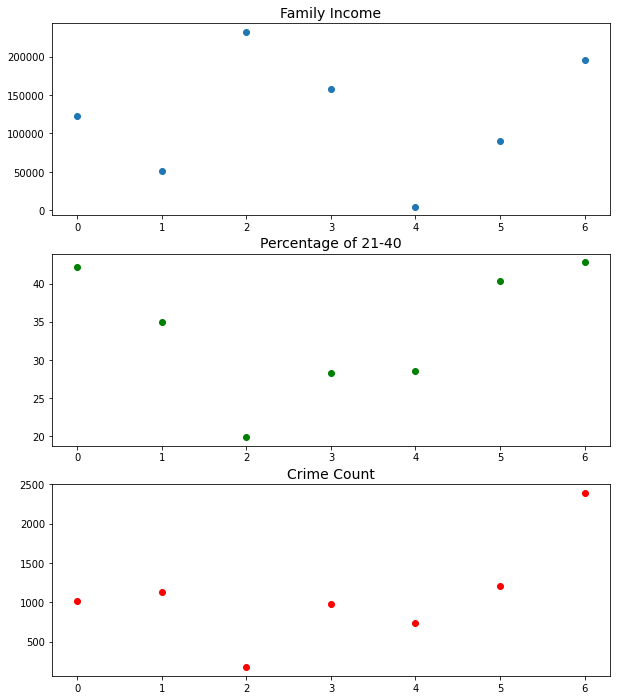

In [102]:
# plotting the three main features to select the best clusters to proceed with
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(311) # three rows, one column, first plot
ax.scatter(nbr_stats['cluster labels'], nbr_stats['family_income'])
ax.set_title('Family Income', fontsize=14)

ax1 = fig.add_subplot(312) # three rows, one column, second plot
ax1.scatter(nbr_stats['cluster labels'], nbr_stats['pct_21-40'], c='green')
ax1.title.set_label('Percentage of Population 21-40')
ax1.set_title('Percentage of 21-40', fontsize=14)

ax2 = fig.add_subplot(313) # three rows, one column, third plot
ax2.scatter(nbr_stats['cluster labels'], nbr_stats['Crime_Count'], c='red')
ax2.set_title('Crime Count', fontsize=14)

Based on the results above we will select clusters 0 and 5. We are doing this because
* Both areas have a high percentage of 21-40 age group (above 40%).
* The income levels in both areas is high enough to be able to spend on eating out.
* The crime count is within mean range.

In [0]:
# selecting group 0 and 5
nbr_select = df_clust.loc[df_clust['cluster labels'].isin ([0, 5])]

In [34]:
nbr_select.head()

,cluster labels,population,num_houses,MALE,FEMALE,under20,21-40,41-60,above 60,hh_income,family_income,PCT_POVERTY,lat,lon,Crime_Count,pct_21-40
neighborhood,,,,,,,,,,,,,,,,
capitol hill,5,14708.0,11757.0,8331.0,6377.0,562.0,9436.0,3216.0,1494.0,45296,85005,17.333333,39.735581,-104.977276,3315,64.155562
hampden south,5,14370.0,7787.0,6974.0,7396.0,2828.0,4575.0,3708.0,3259.0,69930,99149,4.833333,39.626882,-104.894224,1156,31.837161
virginia village,5,12844.0,6591.0,6487.0,6357.0,2655.0,4440.0,3486.0,2263.0,62578,74919,15.275000,39.680645,-104.926085,929,34.568670
five points,5,12712.0,7147.0,7440.0,5272.0,1615.0,6878.0,3159.0,1060.0,63316,90983,22.233333,39.754698,-104.988366,5759,54.106356
marston,5,11132.0,5462.0,5289.0,5843.0,2472.0,3749.0,3130.0,1781.0,65634,77691,5.150000,39.626475,-105.094382,682,33.677686


In [0]:
#CLIENT_ID = 'your-ID' # your Foursquare ID
#CLIENT_SECRET = 'secret-key' # your Foursquare Secret
#VERSION = '20180605' # Foursquare API version

In [0]:
CLIENT_ID = 'TOVSYQWMUMXBNSMSSKTDJ314XDSA2PM10DWJP0VLCUN5NR5C' # your Foursquare ID
CLIENT_SECRET = 'RPFGSS4CJYAAJ2DMKO0JHPOGWX5DQID2XQGSUPEAL054HOR4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Getting neighborhood data for venues, we will first create a call to foursquare API to do a venue search for neighborhood

In [0]:
venues_list=[]
radius = 2000
LIMIT = 50

for name, lat, lng in zip(nbr_select.index, nbr_select['lat'], nbr_select['lon']):
                
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
            
    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']
        
    # return only relevant information for each nearby venue
    venues_list.append([(
        name, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

In [41]:
# Checking repsonse from venues, change the index number if you want to confirm
venues_list[31]

[('skyland',
  39.7603798,
  -104.9503425,
  'The Plimoth',
  39.757123856791885,
  -104.95888451046136,
  'French Restaurant'),
 ('skyland',
  39.7603798,
  -104.9503425,
  'Denver Zoo',
  39.75026511816957,
  -104.94889714051321,
  'Zoo'),
 ('skyland',
  39.7603798,
  -104.9503425,
  'Rivers And Roads Coffee',
  39.76470124298877,
  -104.95652108976233,
  'Coffee Shop'),
 ('skyland',
  39.7603798,
  -104.9503425,
  'Toyota Elephant Passage',
  39.74853175780098,
  -104.9491256425972,
  'Zoo Exhibit'),
 ('skyland',
  39.7603798,
  -104.9503425,
  'Bird World at Denver Zoo',
  39.74940410974774,
  -104.95272303219365,
  'Zoo Exhibit'),
 ('skyland',
  39.7603798,
  -104.9503425,
  'Tropical Discovery at Denver Zoo',
  39.749213812756274,
  -104.94651271179167,
  'Zoo Exhibit'),
 ('skyland',
  39.7603798,
  -104.9503425,
  'Denver Museum of Nature and Science',
  39.747966329429524,
  -104.94274529449719,
  'Science Museum'),
 ('skyland',
  39.7603798,
  -104.9503425,
  'Sea Lions at Den

In [42]:
# organizing results in a dataframe
df_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
df_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
df_venues.shape

(1720, 7)

In [43]:
df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,capitol hill,39.735581,-104.977276,Hudson Hill,39.736960,-104.979407,Cocktail Bar
1,capitol hill,39.735581,-104.977276,Snarf's Sandwiches,39.733891,-104.975320,Sandwich Place
2,capitol hill,39.735581,-104.977276,Wax Trax Records,39.736810,-104.979230,Record Shop
3,capitol hill,39.735581,-104.977276,Jelly Cafe,39.736791,-104.979730,Breakfast Spot
4,capitol hill,39.735581,-104.977276,The Corner Beet,39.738534,-104.975424,Juice Bar


<h3>Analyzing Neighborhood</h3>

One hot encoding the venues. This code snippet was taken from the excercise workbook.

In [44]:
# one hot encoding for type of venues
venues_1h = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_1h['Neighborhood'] = df_venues['Neighborhood']

# grouping by neighborhood
venues_grouped = venues_1h.groupby('Neighborhood').mean().reset_index()
venues_grouped

,Neighborhood,ATM,Alternative Healer,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach Bar,Beer Garden,Bike Shop,Bistro,Bookstore,Botanical Garden,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Chinese Restaurant,Chiropractor,Clothing Store,Cocktail Bar,Coffee Shop,...,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Track,Trade School,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,baker,0.000000,0.00,0.060000,0.00,0.04,0.00,0.02,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.080000,0.00,0.00,0.02,0.000000,0.00,0.00,0.02,0.00,0.00,0.040000,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.000000,0.00,0.04,0.00,0.040000,...,0.00,0.00,0.000000,0.000000,0.00,0.02,0.000000,0.020000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.020000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.02,0.00,0.000000,0.000000,0.02,0.00,0.00
1,bear valley,0.042553,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.021277,0.000000,0.00,0.042553,0.021277,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.042553,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021277,0.00,0.00,0.00,0.042553,...,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.021277,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.042553,0.00,0.00,0.000000,0.00,0.00,0.00,0.021277,0.021277,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00
2,berkeley,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.020000,0.000000,0.02,0.000000,0.040000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.02,0.040000,0.08,0.00,0.00,0.02,0.02,0.00,0.02,0.00,0.00,0.000000,0.00,0.00,0.02,0.060000,...,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.02,0.020000,0.00,0.00,0.00,0.00,0.02,0.000000,0.02,0.000000,0.00,0.00,0.000000,0.00,0.00,0.02,0.000000,0.000000,0.00,0.00,0.00,0.02,0.000000,0.000000,0.02,0.00,0.00
3,capitol hill,0.000000,0.00,0.060000,0.00,0.02,0.02,0.00,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.020000,0.00,0.00,0.00,0.000000,0.02,0.00,0.02,0.00,0.00,0.040000,0.04,0.00,0.00,0.02,0.00,0.02,0.00,0.00,0.00,0.000000,0.00,0.00,0.02,0.020000,...,0.02,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.020000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.02,0.00,0.000000,0.00,0.00,0.04,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.04,0.00,0.00
4,cheesman park,0.000000,0.00,0.080000,0.00,0.02,0.00,0.00,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.020000,0.00,0.00,0.00,0.000000,0.02,0.00,0.00,0.00,0.00,0.060000,0.02,0.00,0.00,0.02,0.00,0.02,0.02,0.00,0.00,0.000000,0.00,0.00,0.02,0.020000,...,0.02,0.00,0.000000,0.000000,0.00,0.02,0.000000,0.020000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.02,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.02,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.04,0.00,0.00
5,city park,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.040000,0.00,0.00,0.00,0.000000,0.00,0.02,0.02,0.02,0.00,0.040000,0.04,0.00,0.00,0.02,0.00,0.00,0.02,0.00,0.00,0.000000,0.00,0.00,0.00,0.060000,...,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.02,0.000000,0.000000,0.00,0.00,

In [45]:
venues_grouped.shape

(35, 204)

In [0]:
# A funtion to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,baker,Bar,American Restaurant,Marijuana Dispensary,Breakfast Spot,Coffee Shop,Brewery,Pizza Place,Art Gallery,Clothing Store,Sports Bar
1,bear valley,Mexican Restaurant,Hotel,Convenience Store,ATM,Coffee Shop,Breakfast Spot,Pizza Place,Park,Thrift / Vintage Store,Bank
2,berkeley,Brewery,Coffee Shop,Pizza Place,Park,Mexican Restaurant,Bar,Liquor Store,Breakfast Spot,Sushi Restaurant,Lounge
3,capitol hill,Sandwich Place,American Restaurant,Yoga Studio,Breakfast Spot,Brewery,Liquor Store,Vegetarian / Vegan Restaurant,Record Shop,Cocktail Bar,Burger Joint
4,cheesman park,Sandwich Place,American Restaurant,Pizza Place,Mexican Restaurant,Breakfast Spot,Ice Cream Shop,Liquor Store,Yoga Studio,Diner,Smoke Shop


<h2>Final Selection Neighborhoods</h2>

Find the neighborhoods with highest concentration of bars and brewries and lowest number of mexican restaurants.

In [48]:
# Getting the list where the first most common venue is a bar or brewery
final_list = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['1st Most Common Venue'].isin (['Bar', 'Brewery'])]
final_list

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,baker,Bar,American Restaurant,Marijuana Dispensary,Breakfast Spot,Coffee Shop,Brewery,Pizza Place,Art Gallery,Clothing Store,Sports Bar
2,berkeley,Brewery,Coffee Shop,Pizza Place,Park,Mexican Restaurant,Bar,Liquor Store,Breakfast Spot,Sushi Restaurant,Lounge
9,five points,Brewery,Pizza Place,Bar,Restaurant,Coffee Shop,Sandwich Place,Lounge,Burger Joint,Gym / Fitness Center,Deli / Bodega
20,regis,Brewery,Pizza Place,Bar,Coffee Shop,Park,Mexican Restaurant,Liquor Store,Breakfast Spot,Brazilian Restaurant,Scenic Lookout
34,whittier,Brewery,American Restaurant,Pizza Place,Coffee Shop,Bar,Park,New American Restaurant,Music Venue,Café,Sports Bar


In [67]:
# getting the stats for the top 5 candidates
df_combined.loc[final_list['Neighborhood'].values]

,population,num_houses,MALE,FEMALE,under20,21-40,41-60,above 60,hh_income,family_income,PCT_POVERTY,lat,lon,Crime_Count
neighborhood,,,,,,,,,,,,,,
baker,4879.0,2697.0,2565.0,2314.0,823.0,2208.0,1299.0,549.0,67996,83877,16.800000,39.710262,-104.989994,1530
berkeley,8112.0,4322.0,3884.0,4228.0,1410.0,3027.0,2232.0,1443.0,77070,104158,8.400000,39.777990,-105.044876,738
five points,12712.0,7147.0,7440.0,5272.0,1615.0,6878.0,3159.0,1060.0,63316,90983,22.233333,39.754698,-104.988366,5759
regis,3934.0,1686.0,1884.0,2050.0,950.0,1333.0,1006.0,645.0,68342,88272,16.900000,39.787971,-105.045320,454
whittier,4831.0,2150.0,2380.0,2451.0,1226.0,1962.0,1104.0,539.0,74611,79196,15.700000,39.753426,-104.969991,553


Out of the five possible locations the best location for the food truck would be in the five points area followed by berkeley. This is because these areas plenty of spots for a food truck to set up at (bars or brewries). Additionally the population is higher than the other three spots and the income levels are high enough to support discretionary spending.

The five points is especially more attractive because of high proportion of the 21-40 age group population.

In terms of competition these areas have no mexican restuarant within top 10 venue locations making the taco truck a unique offering potentially incresing the revenues.